In [1]:
%cd ..

import torch
from transformers import BertForMaskedLM, BertConfig, Trainer, TrainingArguments
from inpainting.datasets import MNIST

/home/ventus/image-inpainting


2025-01-20 15:30:23.420488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 15:30:23.433038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 15:30:23.436492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 15:30:23.446900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 15:30:24.395229: W tensorflow/compiler/tf2

In [2]:
mnist = MNIST(frac=0.01)

In [3]:
model = BertForMaskedLM(config=BertConfig(vocab_size=mnist.tokens+1, pad_token_id=mnist.tokens, max_position_embeddings=7*7)) #mnist.tokens))

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
# Training arguments
training_args = TrainingArguments(
    output_dir="saved/bert_mlm_custom",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    logging_dir="saved/bert_mlm_custom/logs",
    logging_steps=10,
    save_steps=1000,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mnist,
)

In [5]:
trainer.train()

  0%|          | 0/900 [00:00<?, ?it/s]

{'loss': 2.7349, 'grad_norm': 3.75581955909729, 'learning_rate': 4.9444444444444446e-05, 'epoch': 0.03}
{'loss': 2.113, 'grad_norm': 8.618873596191406, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.07}
{'loss': 2.0468, 'grad_norm': 4.734762191772461, 'learning_rate': 4.8333333333333334e-05, 'epoch': 0.1}
{'loss': 1.8852, 'grad_norm': 5.370517730712891, 'learning_rate': 4.7777777777777784e-05, 'epoch': 0.13}
{'loss': 1.7038, 'grad_norm': 5.162893772125244, 'learning_rate': 4.722222222222222e-05, 'epoch': 0.17}
{'loss': 1.5044, 'grad_norm': 4.694304943084717, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.2}
{'loss': 1.462, 'grad_norm': 4.7805986404418945, 'learning_rate': 4.6111111111111115e-05, 'epoch': 0.23}
{'loss': 1.2537, 'grad_norm': 4.5215535163879395, 'learning_rate': 4.555555555555556e-05, 'epoch': 0.27}
{'loss': 1.1396, 'grad_norm': 4.398157596588135, 'learning_rate': 4.5e-05, 'epoch': 0.3}
{'loss': 0.9805, 'grad_norm': 3.811258316040039, 'learning_rate': 4.4444444444

TrainOutput(global_step=900, training_loss=0.556899463335673, metrics={'train_runtime': 38.1421, 'train_samples_per_second': 47.192, 'train_steps_per_second': 23.596, 'total_flos': 45325202076000.0, 'train_loss': 0.556899463335673, 'epoch': 3.0})

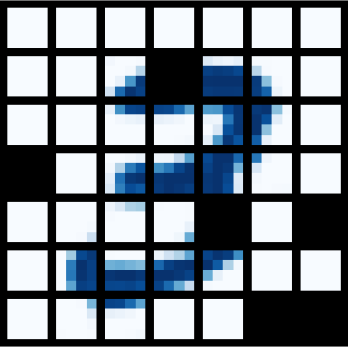

In [6]:
x = mnist[7]["input_ids"]
mnist.plot_sample(x)

In [7]:

model.eval()  # Set the model in evaluation mode (turn off dropout, batch norm in eval mode)
with torch.no_grad():  # Disable gradient calculation
    outputs = model(x.unsqueeze(0).cuda()).logits.detach().cpu()

In [8]:
y = torch.softmax(outputs, dim=-1).argmax(dim=-1)

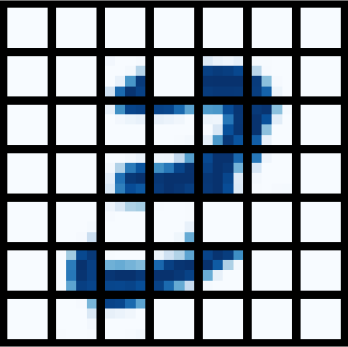

In [9]:
mnist.plot_sample(y)